# Data Sampling to compile daily data into weekly samples

# 1. Sample generation

**Note:** This notebook helps create different types of sampling (i.e., random sampling and stratified sampling) with each daily data set and then concatentas them into a weekly data set.

<div class="alert alert-block alert-warning">
  
<b>Notebook objectives:</b>
    
* Define functions to generate various types of sampling out of a full day level data set
    

* The following data sampling methods are defined in function form:
    
    - Random Sample
    - Stratified Samling using an input variable (i.e., a variable that wants to be used as distribution base)
    - Stratified Sampling using the target feature
    
    
* Export new generated data samples in pickle form to local directory
    
    
* Finally, a plot is generated using the data imbalance ratio to understand if there's an stabilization at daily data level
    
    

## 1.1 Load packages

In [1]:
##### Importing packages

# Data handling
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn') # pretty graphs
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, FuncFormatter, MultipleLocator, AutoMinorLocator
from IPython.display import HTML, Image #display formatted texts
import warnings
warnings.filterwarnings('ignore')

# File format handling
import pickle
import bz2
import _pickle as cPickle

# stratified sampling
from sklearn.model_selection import train_test_split

# random state
seed = 2323

# Path set up (If a new directory is used all of the paths need to be updated)

path = "/project/data/" 
path_w1 = "/project/data/w1/"
path_w2 = "/project/data/w2/"
path_w3 = "/project/data/w3/"
path_w4 = "/project/data/w4/"
path_w5 = "/project/data/w5/"
json_path = "/project/KEYFILE.json"

## 1.2 Pre-defined functions

These functions are used to generate different types of samples (i.e., random samples, stratified target feature, stratified 'time of the day' feature).

In [2]:
###### Pre-defined functions

###### RANDOM SAMPLES GENERATOR

def get_random_sampled_df(pickles_path, sample_size = 0.2):
    
    '''
    This function generates a new data frame from random samples a provided pickles file repository. 
    It receives as inputs:
    - pickle_path = path for the pickle files for each week (i.e.,path_w1, path_w2, etc.)
    - sample_size = generates a random sample equals to this percentage. Default value 0.2
    '''
    
    # list of all pickles in the provided repository
    pickles_list = ['client_day_1', 'client_day_2', 'client_day_3', 'client_day_4', 'client_day_5', 'client_day_6', 'client_day_7']
    
    samples = []
    for idx, pickle in enumerate(pickles_list):
        pickled_data = bz2.BZ2File(pickles_path + pickle, 'rb')
        n_df = cPickle.load(pickled_data)
        pickled_data.close()
        sample_random = n_df.sample(frac = sample_size, random_state = seed)
        samples.append(sample_random)

    for s in samples:
        new_df = pd.concat([*samples], ignore_index = True)
    
    print(F'New data frame from samples generated with {new_df.shape[0]} rows and {new_df.shape[1]} columns')
    return new_df

###### STRATIFIED RANDOM SAMPLES GENERATOR BASED IN 'TIME OF DAY' FEATURE

def get_stratified_sample_df(pickles_path, 
                             strata_features = ['Time of Day'],
                             sample_size = 0.15):
    
    '''
    This function generates a new data frame from random samples following a stratified distributions. 
    It receives as inputs:
    - pickle_path = path for the pickle files for each week (i.e.,path_w1, path_w2, etc.)
    - strata_features = features from which a distribution sampling is based on
    - sample_size = generates a random sample equals to this percentage. Default value 0.15
    '''
    
    # list of all pickles in the provided repository
    pickles_list = ['client_day_1', 'client_day_2', 'client_day_3', 'client_day_4', 'client_day_5', 'client_day_6', 'client_day_7']
    
    # store dayly samples
    samples_strfd = []
    for idx, pickle in enumerate(pickles_list):
        pickled_data = bz2.BZ2File(pickles_path + pickle, 'rb')
        n_df = cPickle.load(pickled_data)
        pickled_data.close()
        subset = list(n_df.columns[~n_df.columns.str.contains(pat = 'ID', regex= True)]) #mremoves ID columns
        n_df = n_df[subset]
        n_df.dropna(inplace=True) #removes NAs
        n_df['Time of Day'] = n_df['Time of Day'].astype('str') # get time of day as str
        strfd_sample_train, strfd_sample_test = train_test_split(n_df, test_size = sample_size, stratify = n_df[strata_features], random_state = seed)
        samples_strfd.append(strfd_sample_test)

    for s in samples_strfd:
        new_df = pd.concat([*samples_strfd], ignore_index = True)
        
    print(F'New data frame from stratified samples generated with {new_df.shape[0]} rows and {new_df.shape[1]} columns')
    return new_df

###### STRATIFIED TARGET FEATURE RANDOM SAMPLES GENERATOR

def get_stratified_target_sample_df(pickles_path, sample_size = 0.15):
    
    '''
    This function generates a new data frame from random samples following a stratified distributions of the target feature. 
    It receives as inputs:
    - pickle_path = path for the pickle files for each week (i.e.,path_w1, path_w2, etc.)
    - sample_size = generates a random sample equals to this percentage (default value = 0.15)
    '''
    
    # list of all pickles in the provided repository
    pickles_list = ['client_day_1', 'client_day_2', 'client_day_3', 'client_day_4', 'client_day_5', 'client_day_6', 'client_day_7']

    samples_strfd = []
    # load daily pickled files
    for idx, pickle in enumerate(pickles_list):
        pickled_data = bz2.BZ2File(pickles_path + pickle, 'rb')
        n_df = cPickle.load(pickled_data)
        pickled_data.close()
        
    # data pre-processing to generate stratified sample
        subset = list(n_df.columns[~n_df.columns.str.contains(pat = 'ID', regex= True)]) #mremoves ID columns
        n_df = n_df[subset]
        n_df.dropna(inplace=True) #removes NAs
        n_df['Time of Day'] = n_df['Time of Day'].astype('str') # get time of day as str

    # get 'X' and 'y' matrixes to generate stratified sample
        n_df['user_response'] = np.where(n_df['Clicks'] == 0, 0, 1) # generates target feature
        x_columns_list = list(n_df.columns[~n_df.columns.str.contains(pat = 'user_response', regex= True)])
        y = n_df['user_response']
        X = n_df[x_columns_list]
    
    # stratified sample
        X_strfd_sample_train, X_strfd_sample_test, y_strfd_sample_train, y_strfd_sample_test = train_test_split(X, y, test_size = sample_size, stratify = y,random_state = seed)
    
    #return final df
        temp_df = pd.concat([X_strfd_sample_test, y_strfd_sample_test], axis=1)
        samples_strfd.append(temp_df)

    for s in samples_strfd:
        final_df = pd.concat([*samples_strfd], axis=0)
        
    print(F"New data frame from stratified samples generated with {final_df.shape[0]} rows and {final_df.shape[1]} columns\ntarget feature proportion = {final_df['user_response'].value_counts(normalize = True, sort = True)[1]:.4%}")
    return final_df

## 1.3 Random samples

**Note**: provide a weekly path (e.g path_w1) at a time to avoid running out of memory.

In [ ]:
# Run pre-defined function to generate random sample by week
w5_df = get_random_sampled_df(path_w2, sample_size = 0.05)

In [ ]:
# transform new random sample into pickle file
sfile = bz2.BZ2File(path_w5 + 'sample_w5_5pct', 'w')
pickle.dump(w5_df,sfile)
sfile.close()

## 1.4 Stratified samples

**Note**: provide a weekly path (e.g path_w1) at a time to avoid running out of memory.

In [ ]:
# Run pre-defined function to generate stratified random sample by week
new_df = get_stratified_sample_df(path_w5, strata_features = ['Time of Day'], sample_size =0.05)

In [ ]:
# transform new stratified sample to pickle file
sfile = bz2.BZ2File(path_w5 + 'sample_strfd_w5_5pct', 'w')
pickle.dump(new_df,sfile)
sfile.close()

## 1.5 Target feature stratified samples

In [12]:
strata_target_df = get_stratified_target_sample_df(path_w5, sample_size = 0.05)

New data frame from stratified samples generated with 1057053 rows and 41 columns
target feature proportion = 0.0967%


In [13]:
# transform new stratified sample to pickle file
sfile = bz2.BZ2File(path_w5 + 'strata_target_w5_5pct', 'w')
pickle.dump(strata_target_df,sfile)
sfile.close()

## 1.6 Data size vs class imbalance

Understanding how class imbalance for user response in clicks (i.e., 0 - No clicks; 1 - At least a click) behaves as data size increases.

In [3]:
### Compute data size and class imbalance data frame for 3 weeks

pickles_list = ['client_day_1', 'client_day_2', 'client_day_3', 'client_day_4', 'client_day_5', 'client_day_6', 'client_day_7']

size = []
class_imbalance = []

# load w1 data
for idx, pickle in enumerate(pickles_list):
    pickled_data = bz2.BZ2File(path_w1 + pickle, 'rb')
    n_df = cPickle.load(pickled_data)
    pickled_data.close()

    n_df['user_response'] = np.where(n_df['Clicks'] == 0, 0, 1)
# store w1 values
    size.append(n_df.shape[0])
    class_imbalance.append(n_df['user_response'].value_counts(normalize = True, sort = True)[1])

# load w2 data
for idx, pickle in enumerate(pickles_list):
    pickled_data = bz2.BZ2File(path_w2 + pickle, 'rb')
    n2_df = cPickle.load(pickled_data)
    pickled_data.close()

    n2_df['user_response'] = np.where(n2_df['Clicks'] == 0, 0, 1)
# store w2 values
    size.append(n2_df.shape[0])
    class_imbalance.append(n2_df['user_response'].value_counts(normalize = True, sort = True)[1])
    
# load w3 data
for idx, pickle in enumerate(pickles_list):
    pickled_data = bz2.BZ2File(path_w3 + pickle, 'rb')
    n3_df = cPickle.load(pickled_data)
    pickled_data.close()

    n3_df['user_response'] = np.where(n3_df['Clicks'] == 0, 0, 1)
    
# store w3 values
    size.append(n3_df.shape[0])
    class_imbalance.append(n3_df['user_response'].value_counts(normalize = True, sort = True)[1])

# create new data frame with data size and class imbalance proportion
new_df = pd.DataFrame(list(zip(size, class_imbalance)),
           columns =['Total num instances', 'class imbalance'], index =['day 1', 'day 2', 'day 3', 'day 4', 'day 5', 'day 6', 'day 7',
                                                                       'day 8', 'day 9', 'day 10', 'day 11', 'day 12', 'day 13', 'day 14',
                                                                       'day 15', 'day 16', 'day 17', 'day 18', 'day 19', 'day 20', 'day 21'])

new_df['cumulative num instances'] = new_df['Total num instances'].cumsum()
new_df['mean class imbalance'] = new_df['class imbalance'].expanding().mean() * 100

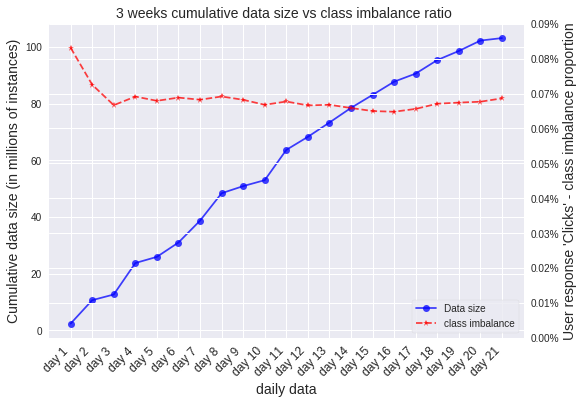

In [14]:
##### Plotting data size vs class imbalance

### Set up for plotting
fig, ax = plt.subplots(constrained_layout=True)

ax1 = plt.subplot()
l1, = ax1.plot(new_df['cumulative num instances']/1000000, color = 'blue', marker='o' ,alpha = 0.75)
ax2 = ax1.twinx()
l2, = ax2.plot(new_df['mean class imbalance'], color='red', linestyle='--', marker='*', alpha = 0.75)

### x axis set up
x_axis = np.arange(len(new_df.index))
ax1.set_xticks(ticks = x_axis)
ax1.set_xticklabels(new_df.index, rotation = 45, fontsize = 12, horizontalalignment = 'right') # temp_df[var][::5]
ax1.set_xlabel("daily data", fontsize = 14)

### left y axis set up
ax1.set_ylabel('Cumulative data size (in millions of instances)', fontsize = 14)


### right y axis set up
yticks_right = mticker.FormatStrFormatter('%.2f%%')
ax2.yaxis.set_major_formatter(yticks_right)
ax2.yaxis.set_ticks(np.arange(0.0, 0.10, 0.01))
ax2.set_ylabel("User response 'Clicks' - class imbalance proportion", fontsize = 14)

ax1.set_title('3 weeks cumulative data size vs class imbalance ratio ', fontsize = 14)
# fig.suptitle('3 weeks cumulative data size vs class imbalance ratio ', fontsize =12)


### legend set up
plt.legend([l1, l2], ["Data size", "class imbalance"], loc = 'lower right', frameon = True)

plt.show()

# Appendix

### A. Load into memory a complete week data

In [ ]:
### Load a complete week from pickle files
pickles_list = ['client_day_1', 'client_day_2', 'client_day_3', 'client_day_4', 'client_day_5', 'client_day_6', 'client_day_7']

days_list= []
for pickle in pickles_list:
    pickled_data = bz2.BZ2File(path_w1 + pickle, 'rb')
    temp_df = cPickle.load(pickled_data)
    pickled_data.close()
    days_list.append(temp_df)

for day in days_list:
    week_df = pd.concat([*days_list], axis=0) 

In [ ]:
# transform new stratified sample to pickle file
sfile = bz2.BZ2File(path_w1 + 'complete_week1', 'w')
pickle.dump(week_df,sfile)
sfile.close()

### B. Create a data set size and class imbalance data frame

In [ ]:
### Compute data size and class imbalance data frame for 1 week

# list of all pickles in the provided repository
pickles_list = ['client_day_1', 'client_day_2', 'client_day_3', 'client_day_4', 'client_day_5', 'client_day_6', 'client_day_7']

size = []
class_imbalance = []

# load pickled files from daily data
for idx, pickle in enumerate(pickles_list):
    pickled_data = bz2.BZ2File(path_w1 + pickle, 'rb')
    n_df = cPickle.load(pickled_data)
    pickled_data.close()

# target feature 'user response'
    n_df['user_response'] = np.where(n_df['Clicks'] == 0, 0, 1)

# append total number of instance and class imbalance ratio
    size.append(n_df.shape[0])
    class_imbalance.append(n_df['user_response'].value_counts(normalize = True, sort = True)[1])

new_df = pd.DataFrame(list(zip(size, class_imbalance)),
           columns =['Total num instances', 'target class imbalance'], index =['day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7'])

## Exporting as csv

In [ ]:
w1_df.to_csv(path + 'sample_w1_5pct.csv', index = True, index_label = False)

In [ ]:
w2_df.to_csv(path + 'sample_w2_15pct.csv', index = True, index_label = False)

In [ ]:
w3_df.to_csv(path + 'sample_w3_5pct.csv', index = True, index_label = False)